# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

<span style="font-width:bold; font-size: 1.4rem;">This notebook explains how to create a feature view, create a training dataset, train a model and save it in the Hopsworks Model Registry.</span>

## 🗒️ This notebook is divided into the following sections:

1. Fetch Feature Groups.
2. Create a Feature View.
3. Create a Training Dataset.
4. Train a model.
5. Save trained model in the Model Registry.

![part2](../../images/02_training-dataset.png) 

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
!pip install xgboost --q

In [2]:
import os
import joblib

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

2024-02-20 21:27:58,492 INFO: generated new fontManager


## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/5242
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieval </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select_all().join(
    weather_fg.select_except(['unix_time']), 
    on=['city_name', 'date'],
)

In [6]:
# Uncomment this if you would like to view your selected features
# selected_features.show(5)

`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.create_feature_view()` method.

You can specify next parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with data.

In [7]:
# Get or create the 'air_quality_fv' feature view
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    version=1,
    query=selected_features,
)

Feature view created successfully, explore it at 
https://snurran.hops.works/p/5242/fs/5190/fv/air_quality_fv/version/1


For now, your `Feature View` is saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view()`.

## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

To create training dataset you use the `FeatureView.training_data()` method.

Here are some importand things:

- It will inherit the name of FeatureView.

- The feature store currently supports the following data formats for
training datasets: **tfrecord, csv, tsv, parquet, avro, orc**.

- You can choose necessary format using **data_format** parameter.

- **start_time** and **end_time** in order to filter dataset in specific time range.

In [8]:
X, _ = feature_view.training_data(
    description = 'Air Quality dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (8.70s) 


## <span style="color:#ff5f27;">🧬 Modeling</span>

In [9]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the data in the 'city_name' column
label_encoder.fit(X[['city_name']])

# Transform the 'city_name' column data using the fitted encoder
encoded = label_encoder.transform(X[['city_name']])

In [10]:
# Convert the output of the label encoding to a dense array and concatenate with the original data
X = pd.concat([X, pd.DataFrame(encoded)], axis=1)

# Drop columns 'date', 'city_name', 'unix_time' from the DataFrame 'X'
X = X.drop(columns=['date', 'city_name', 'unix_time'])

# Rename the newly added column with label-encoded city names to 'city_name_encoded'
X = X.rename(columns={0: "city_name_encoded"})

In [11]:
# Extract the target variable 'pm2_5' from the DataFrame 'X' and assigning it to the variable 'y'
y = X.pop('pm2_5')

In [12]:
# Split the data into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
)

X_train.head(3)

In [ ]:
y_train.head(3)

## <span style='color:#ff5f27'>🏃🏻‍♂️ Model Training

In [17]:
# Create an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fit the XGBoost Regressor to the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#ff5f27'> ⚖️ Model Validation

In [19]:
# Predict target values on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("⛳️ MSE:", mse)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("⛳️ RMSE:", rmse)

# Calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("⛳️ R^2:", r2)

⛳️ MSE: 23.90455409357784
⛳️ RMSE: 4.889228374046137
⛳️ R^2: 0.7686663896306777


In [20]:
# Create a DataFrame 'df_' to store true and predicted values for evaluation
df_pred = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
})

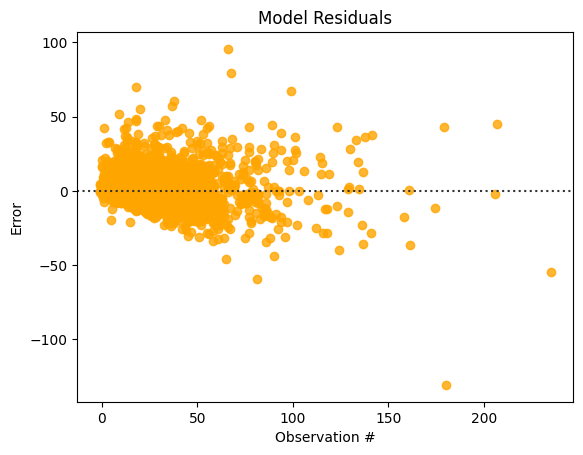

In [21]:
# Create a residual plot using Seaborn
residplot = sns.residplot(data=df_pred, x="y_true", y="y_pred", color='orange')

# Add title, xlabel, and ylabel to the residual plot
plt.title('Model Residuals')
plt.xlabel('Observation #')
plt.ylabel('Error')

# Display the residual plot
plt.show()

# Get the figure from the residual plot and displaying it separately
fig = residplot.get_figure()
fig.show()

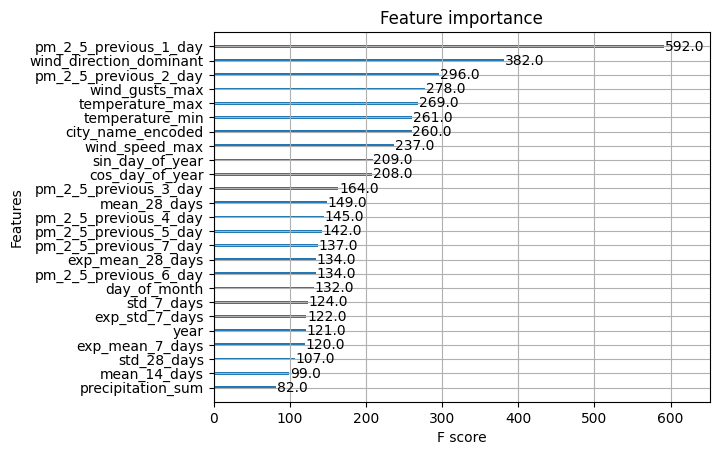

In [24]:
# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    xgb_regressor, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [25]:
# Retrieve the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [26]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Create input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X)
output_schema = Schema(y)

# Create a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Convert the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [27]:
# Create a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save the label encoder and XGBoost regressor as joblib files in the model directory
joblib.dump(label_encoder, model_dir + '/label_encoder.pkl')
joblib.dump(xgb_regressor, model_dir + '/xgboost_regressor.pkl')

# Save the residual plot figure as an image in the model directory
fig.savefig(model_dir + "/residplot.png")

In [28]:
# Create a Python model in the model registry named 'air_quality_xgboost_model'
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics={
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2,
    },
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Save the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://snurran.hops.works/p/5242/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
